In [1]:
%load_ext autoreload
%autoreload 2

In [145]:
from src.data.data import get_engineered_dataloaders
from run.scripts import train_test, check_memory
from torch.nn import HuberLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
import torch

from src.ml.model import EvenMoreGradualPlayerModel
torch.manual_seed(2002)

In [140]:
train_score_dataloader, val_score_dataloader, test_score_dataloader = get_engineered_dataloaders(name=cfg_dict['dataset_name'], x_version=cfg_dict['x_version'], y_version=cfg_dict['y_version'], batch_size=cfg_dict['batch_size'], train_split=cfg_dict['train_split'], val_split=cfg_dict['val_split'], test_split=cfg_dict['test_split'])
mini_train_score_dataloader, mini_val_score_dataloader, mini_test_score_dataloader = get_engineered_dataloaders(name=cfg_dict['dataset_name'], x_version=cfg_dict['x_version'], y_version=cfg_dict['y_version'], batch_size=cfg_dict['batch_size'], train_split=0.08, val_split=0.01, test_split=0.01)

/Users/samharshe/Documents/Programming/TBN/src/data/data.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(processed_dataset_path)


In [188]:
cfg_dict = {
    'name': 'electricity',
    'dataset_name': 'cactus_flower',
    'x_version': 'players',
    'y_version': 'score',
    'batch_size': 16,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'n_epochs': 20,
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'scheduler': 'ReduceLROnPlateau',
    'model': 'EvenMoreGradualPlayerModel',
    'd_mod': 32
}

In [189]:
model = EvenMoreGradualPlayerModel(d_in=65, d_mod=cfg_dict['d_mod'])

final prediction: model(x)
[[0.7170486450195312, 0.7279279828071594], [0.6635247468948364, 0.6852635741233826], [0.6182950735092163, 0.6096104979515076], [0.6048026084899902, 0.6489519476890564]]
actual value: y
[[0.7542856931686401, 0.7215909361839294], [0.6285714507102966, 0.6931818127632141], [0.6628571152687073, 0.6363636255264282], [0.5600000023841858, 0.6193181872367859]]
final loss: 0.0010


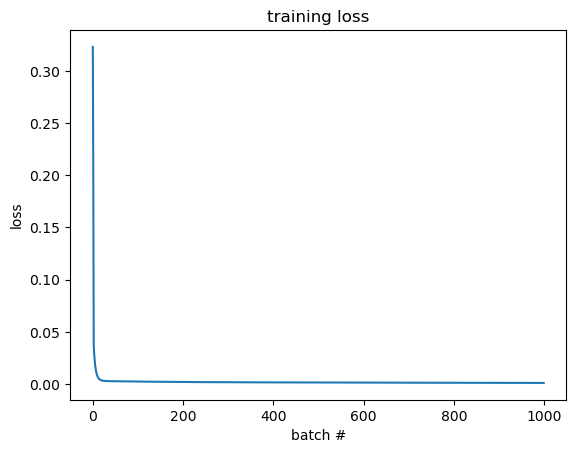

In [190]:
check_memory(model=model, dataloader=train_score_dataloader, n_epochs=1000, batch_size=4, lr=3e-4)

In [186]:
optimizer = Adam(model.parameters(), lr=3e-4)
loss_fn = MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
n_epochs = cfg_dict['n_epochs']

EPOCH 1 OF 20 | electricity | TRAIN MEAN LOSS: 0.018711 | VAL MEAN LOSS: 0.006049
EPOCH 2 OF 20 | electricity | TRAIN MEAN LOSS: 0.007028 | VAL MEAN LOSS: 0.006248
EPOCH 3 OF 20 | electricity | TRAIN MEAN LOSS: 0.006061 | VAL MEAN LOSS: 0.006333
EPOCH 4 OF 20 | electricity | TRAIN MEAN LOSS: 0.005822 | VAL MEAN LOSS: 0.006134
EPOCH 5 OF 20 | electricity | TRAIN MEAN LOSS: 0.005432 | VAL MEAN LOSS: 0.005021
EPOCH 6 OF 20 | electricity | TRAIN MEAN LOSS: 0.005371 | VAL MEAN LOSS: 0.004887
EPOCH 7 OF 20 | electricity | TRAIN MEAN LOSS: 0.005267 | VAL MEAN LOSS: 0.006161
EPOCH 8 OF 20 | electricity | TRAIN MEAN LOSS: 0.005299 | VAL MEAN LOSS: 0.005372
EPOCH 9 OF 20 | electricity | TRAIN MEAN LOSS: 0.005331 | VAL MEAN LOSS: 0.004888
EPOCH 10 OF 20 | electricity | TRAIN MEAN LOSS: 0.005025 | VAL MEAN LOSS: 0.004947
EPOCH 11 OF 20 | electricity | TRAIN MEAN LOSS: 0.005077 | VAL MEAN LOSS: 0.004999
EPOCH 12 OF 20 | electricity | TRAIN MEAN LOSS: 0.005002 | VAL MEAN LOSS: 0.004839
EPOCH 13 OF 2

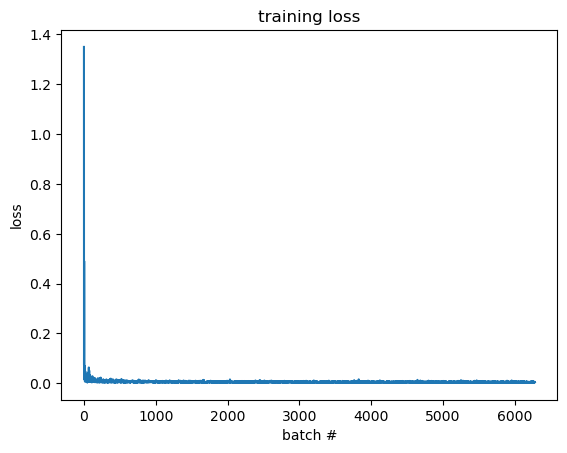

TEST MEAN LOSS: 0.004605
TEST ACCURACY: 0.643879


learning_rate,████▄▄▄▄▄▂▂▂▂▂▂▂▂▂▁▁
test_accuracy,▁
test_mean_loss,▁
train_mean_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_loss,▇██▇▃▂▇▄▂▂▂▂▂▃▂▂▃▄▁▂
learning_rate,4e-05
test_accuracy,0.64388
test_mean_loss,0.00461
train_mean_loss,0.0047
val_mean_loss,0.0049


In [187]:
train_test(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, train_dataloader=train_score_dataloader, val_dataloader=val_score_dataloader, test_dataloader=test_score_dataloader, cfg_dict=cfg_dict)

In [ ]:
cfg_dict.update({
    'train_split': 0.08,
    'val_split': 0.01,
    'test_split': 0.01
})
train_test(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, train_dataloader=mini_train_score_dataloader, val_dataloader=mini_val_score_dataloader, test_dataloader=mini_test_score_dataloader, cfg_dict=cfg_dict)
cfg_dict.update({
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1
})